# Solve the latent variable Gaussian Graphical model using cvxpy

In [1]:
import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
import os
from os import getcwd
from os.path import dirname
from time import gmtime, strftime
import scipy as sp
import cvxpy as cvx
import pywt
from sklearn.preprocessing import binarize
from sklearn.linear_model import lars_path
%matplotlib inline 
import sys

cwd = getcwd()
dir_root = dirname(cwd)
filepath = os.path.join(dir_root, 'src')
sys.path.append(filepath) #('/home/tianpei/Dropbox/Codes/Python/LatNet/src/')
print(filepath)
%load_ext Cython

/home/tianpei/Dropbox/Codes/Python/LatNet/src


In [2]:
from latent_signal_network import latent_signal_network as lsn 

In [3]:
savefigure = False
seed = 1000
choice = 'imported'
d = 90 #600
size = 88 #584
prob = 0
time = 8
option= {'seed': seed, 'node_dim': d, 'model': choice}
option['k-NN'] = 2

## Load data from matlab file

In [4]:
from scipy.io import loadmat
from load_gene_network import load_mat_data, sparse_adjmat_oneshot, detect_isolates

In [5]:
RNA_seq, RNAseq_info = load_mat_data("../data/RNAseq_genes_allT_norm.mat", "RNAseq_genes_allT_norm")

In [6]:
At_Rsimt_resricted_allT, _ = load_mat_data("../data/At_Rsimt_resricted_allT.mat", "At_Rsimt_resricted_allT")

In [7]:
At_Rsimt_resricted_0 = sparse_adjmat_oneshot(At_Rsimt_resricted_allT, time)

## analysis from subgraph

Find a connected subgraph of 100 nodes

In [8]:
n1, n2 = [85, 47]
#n1 = 85  #90    #85  #size of total network
#n2 = 60  #70   #60  #size of a connected subgraph 
node_range = np.arange(n1)
subset_range = 18+np.arange(n2)
subset_range

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64])

In [9]:
LSN = lsn(size, prob, option)
G0, G1, node_lists, node_sets = LSN.graph_from_sparse_adjmat(At_Rsimt_resricted_0, node_range=node_range, subset_range=subset_range)
#G0.remove_nodes_from(nx.isolates(G0)) #remove isolates

In [10]:
print(G0.nodes())

[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 21, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 47, 48, 50, 51, 52, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84]


In [11]:
len(set(G0.nodes()).intersection(set(subset_range)))

37

In [12]:
n1 = len(G0)
n2 = len(G1)
print("size of total graph %d, size of sub-network %d" % (n1, n2))

size of total graph 70, size of sub-network 37


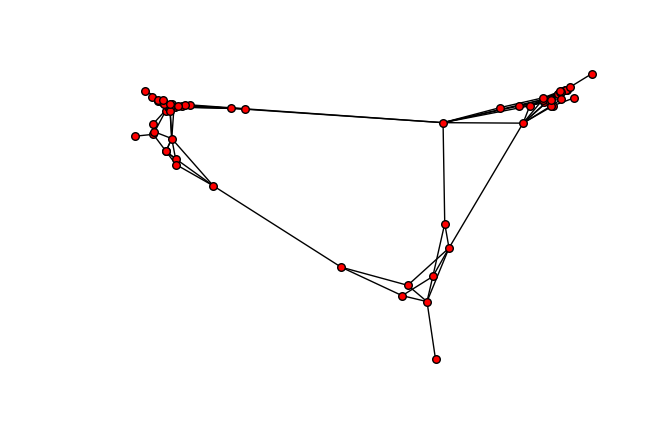

In [13]:
#draw with spectral position, i.e. eigenvectors 
nx.draw_spectral(G0, scale=100, node_size=30)

In [14]:
seed = 30
scale = 100
np.random.seed(seed)
pos_init = dict(zip(G0.nodes(), scale*np.random.rand(len(G0),2)))

See that the given network is low-dimensional on the Graph Fourier Space

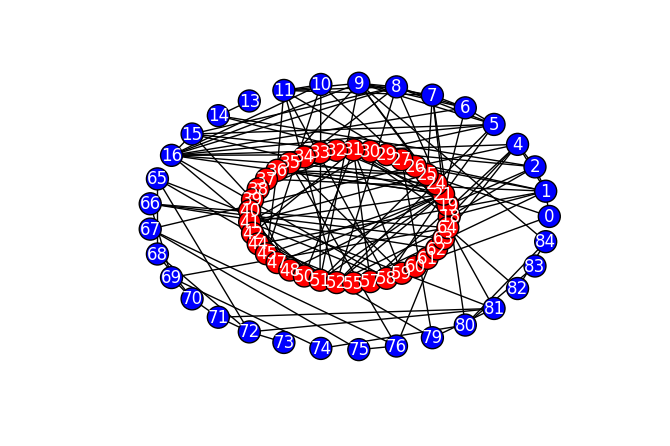

In [15]:
option['draw_scale'] = 2000
pos = nx.shell_layout(G0, [node_lists[0], node_lists[1]]) #nx.nx_pydot.graphviz_layout(G0,  prog='dot')  #nx.circular_layout(G0,  scale=option['draw_scale'])
pos= LSN.draw(G0, option, node_lists=node_lists, pos_init=pos_init, pos=pos, node_size=250, 
              with_labels=True, fontsize=3, font_color='w')

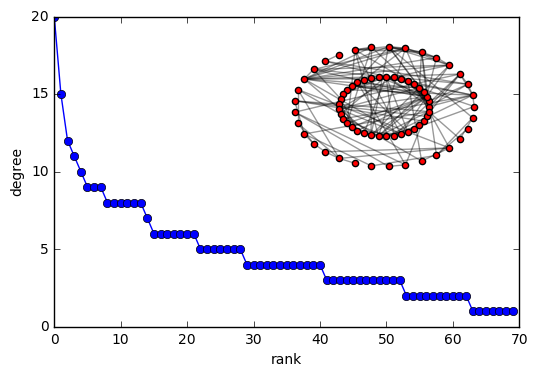

In [16]:
degree_sequence=sorted(nx.degree(G0).values(),reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

fig3 = plt.figure(3)
#plt.loglog(degree_sequence,'b-',marker='o')
plt.plot(degree_sequence,'b-',marker='o')
#plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
plt.axes([0.45,0.45,0.45,0.45])
Gcc=sorted(nx.connected_component_subgraphs(G0), key = len, reverse=True)[0]
#pos=nx.spring_layout(Gcc)
plt.axis('off')
nx.draw_networkx_nodes(Gcc,pos,node_size=20)
nx.draw_networkx_edges(Gcc,pos,alpha=0.4)

filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_degree_rank_plot.eps"
#filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_eigenvalue_adjMat.eps"
if savefigure : fig3.savefig(filename)
plt.show()

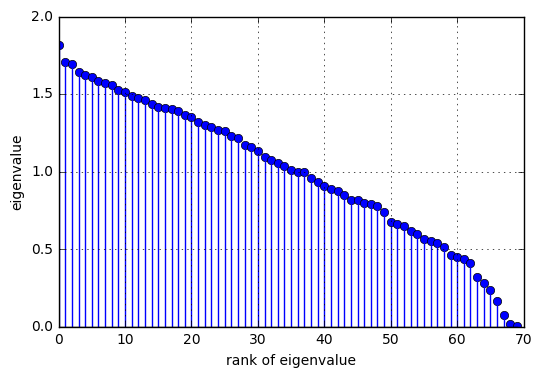

In [17]:
#Plot the eigenvalue of Laplacian matrix
Laplacian = nx.normalized_laplacian_matrix(G0, weight=None).todense()
#Sigma, U = np.linalg.eigh(abs(adjMat))
Sigma, U = np.linalg.eigh(Laplacian)

index_sig = np.argsort(Sigma)
Sigma = Sigma[index_sig[::-1]]
U = U[:,index_sig[::-1]]

fig3 =plt.figure(3)
ax = plt.gca()
(markerline, stemlines, baseline) = plt.stem(np.arange(len(Sigma)), Sigma, 'b', basefmt='k-')
#plt.plot(np.arange(len(Sigma)), np.ones((len(Sigma, ))), 'r')
plt.xlabel('rank of eigenvalue')
plt.ylabel('eigenvalue')
ax.grid(True)
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_eigenvalue_laplacian.eps"
#filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_eigenvalue_adjMat.eps"
if savefigure : fig3.savefig(filename)

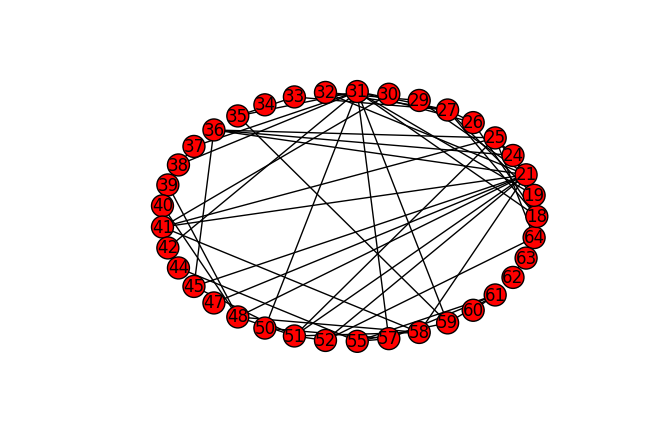

In [18]:
option['draw_scale'] = scale
pos1 = dict(zip(G1.nodes(), [pos[key] for key in G1.nodes()]))
_ = LSN.draw(G1, option, pos=pos1, pos_init=pos_init, with_labels=True, node_size=250, save_fig=savefigure)

In [19]:
Laplacian1 = nx.normalized_laplacian_matrix(G1, weight=None).todense()

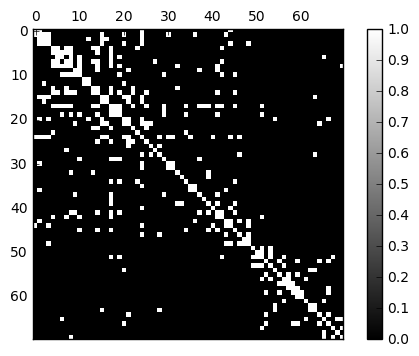

In [20]:
import pywt
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(sp.sign(abs(Laplacian)), cmap=plt.cm.gray)
fig2.colorbar(cax)


plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_cov_all.eps"
if savefigure : fig2.savefig(filename)

Find the complement of the given subgraph G2 in G1

In [21]:
G0_Nodes = G0.nodes()
G1_Nodes = G1.nodes()
G1_complement_Nodes = list(set(G0_Nodes).difference(set(G1_Nodes)))

In [22]:
n3 = len(G1_complement_Nodes)
n3

33

In [23]:
n2

37

In [24]:
G1_complement = G0.subgraph(G1_complement_Nodes)

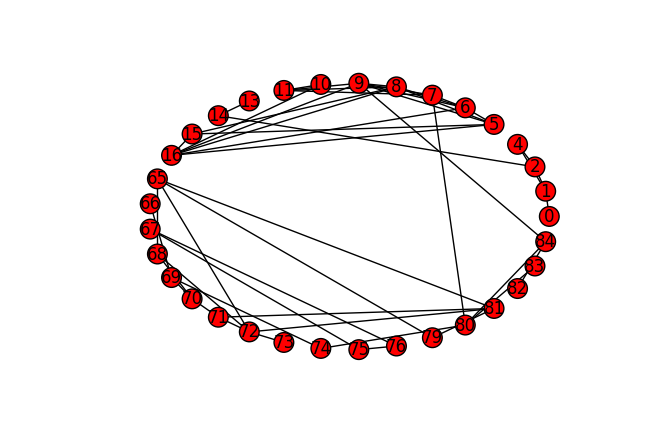

In [25]:
pos1_complement = dict(zip(G1_complement_Nodes, [pos[key] for key in G1_complement_Nodes]))
_ = LSN.draw(G1_complement, option, pos=pos1_complement, pos_init=pos_init, with_labels=True, node_size=200, save_fig=savefigure)

In [26]:
nodeIdx = [{'node': idx, 'loc': i} for i, idx in enumerate(G0.nodes_iter())]
observed_idx = [item['loc'] for item in nodeIdx if item['node'] in node_sets[0]]
hidden_idx = [item['loc'] for item in nodeIdx if item['node'] in node_sets[1]]

## Generate random signal from correlated noise

In [27]:
x = RNA_seq[G0.nodes(),time]
x -= np.mean(x)
x /= np.linalg.norm(x)
r = np.random.randn(d) #a Gaussian scale vector for each 
r /= np.linalg.norm(r)
n = len(x)
scale_factor = np.sqrt(n)

In [28]:
sigma_0 = 10/np.sqrt(d)
power = 0.1

In [29]:
X0_1 = power*scale_factor*np.outer(x, r)

In [30]:
option_sig = {}
option_sig['mat'] = 'laplacian_matrix' #'adjacency_matrix'
choice2 = 'inverse_sqrt'
option_sig['method'] = choice2
if choice2 == 'l1_threshold':
    option_sig['threshold'] = 0.5
elif choice2 == 'polynomial':
    degree_val = np.array(list(G0.degree().values()))
    bias = 1/np.sqrt(np.mean(degree_val))
    option_sig['coeffs'] = [bias, -1, 1, 1/3]
elif choice2 == 'inverse_poly':
    degree_val = np.array(list(G0.degree().values()))
    bias = 1/np.sqrt(np.mean(degree_val))
    option_sig['coeffs'] = [bias, -1, 1, 1/3]    
elif choice2 == 'rescale':
    option_sig['weights'] = np.random.rand((len(G0),))
elif choice2 == 'sigmoid_theshold':
    option_sig['rate'] = 1
    option_sig['shift'] = 0.5
    option_sig['bias'] = 0
elif choice2 == 'inverse_sqrt':
    option_sig['eps'] = 0

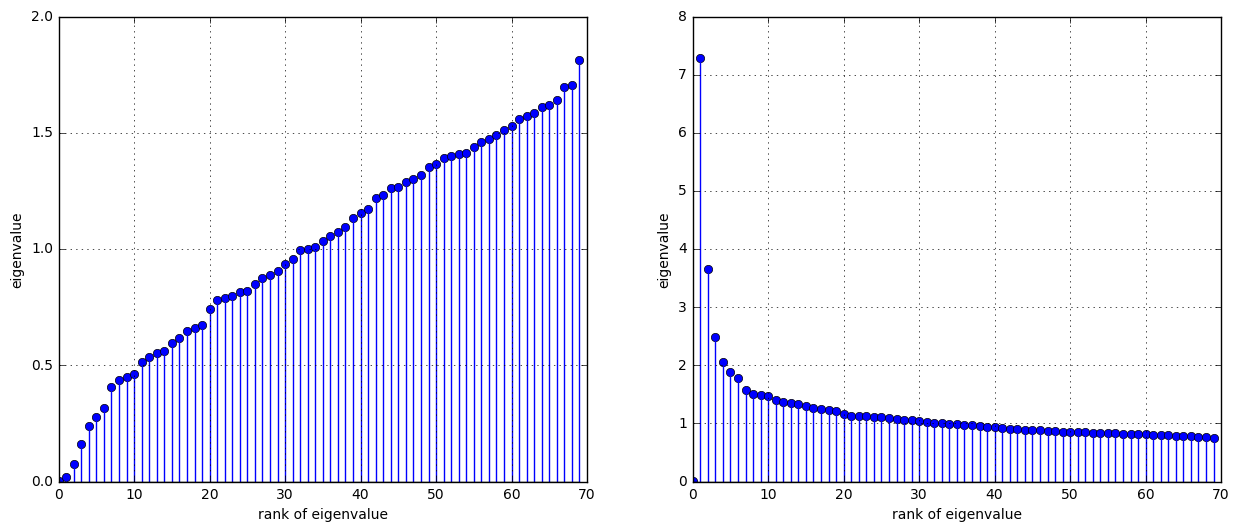

In [31]:
noise = sigma_0*scale_factor*np.random.randn(X0_1.shape[0], X0_1.shape[1])
option
transformed_eigvals, eigvecs, _ = LSN.graph_filter(G0, noise, option_sig, show_plot=True)
noise = np.dot(transformed_eigvals*eigvecs, np.dot(eigvecs.T, noise))
noise -= np.mean(noise, axis=0)
noise /= noise.std(axis=0)

In [32]:

np.linalg.norm(noise)**2

6300.0

In [33]:
print("SNR = %.3f dB" % (10*np.log10(power**2/(np.linalg.norm(noise)**2))))

SNR = -57.993 dB


In [34]:
X0 = X0_1 + noise
#X0 -= np.mean(X0, axis=0)
#X0 /= X0.std(axis=0)

In [35]:
np.mean(X0[0,:])

-0.079670022866918433

In [36]:
n, m = X0.shape
emp_cov = np.cov(X0)

<Container object of 3 artists>

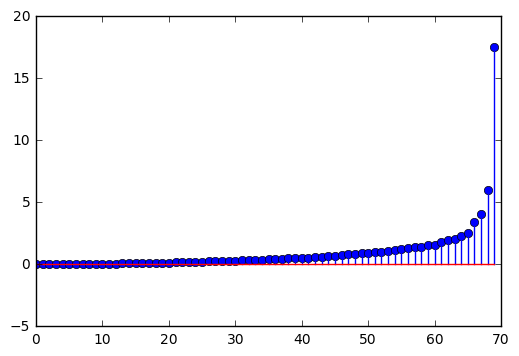

In [37]:
plt.stem(sorted(np.linalg.eigvals(emp_cov)))

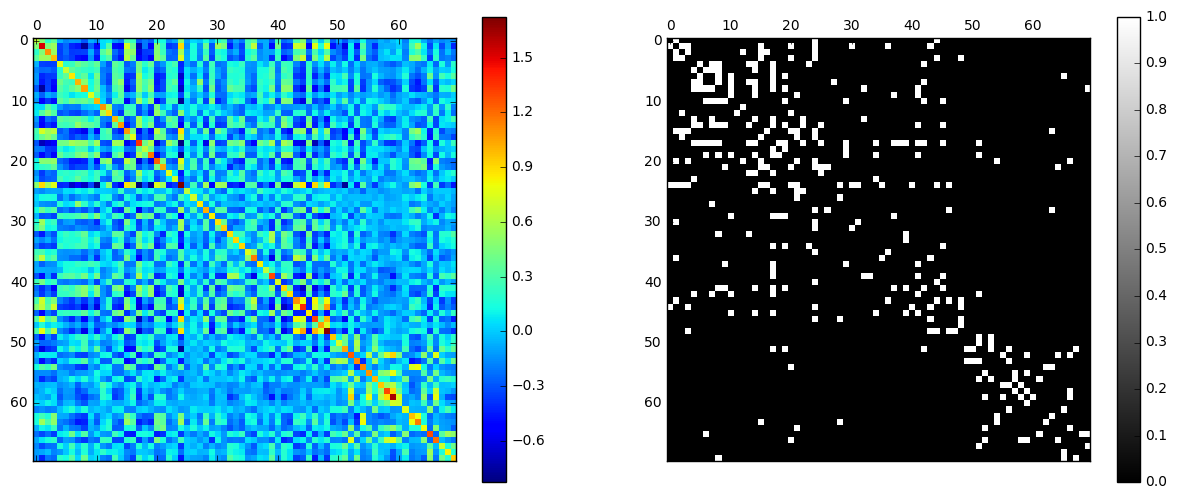

In [38]:
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(emp_cov)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
adjMatSparse =  nx.adjacency_matrix(G0, weight=None)
adjMat = adjMatSparse.todense()
cax = ax.matshow(adjMat, cmap=plt.cm.gray)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_cov_adjmat.eps"
if savefigure : fig2.savefig(filename)

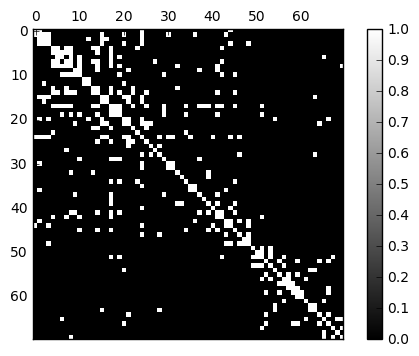

In [39]:

fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(np.sign(abs(Laplacian)), cmap=plt.cm.gray)
fig2.colorbar(cax)


plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_cov_all.eps"
if savefigure : fig2.savefig(filename)

Separate out the hidden and observed data

In [40]:
X_o = X0[observed_idx,:]
X_h = X0[hidden_idx,:]

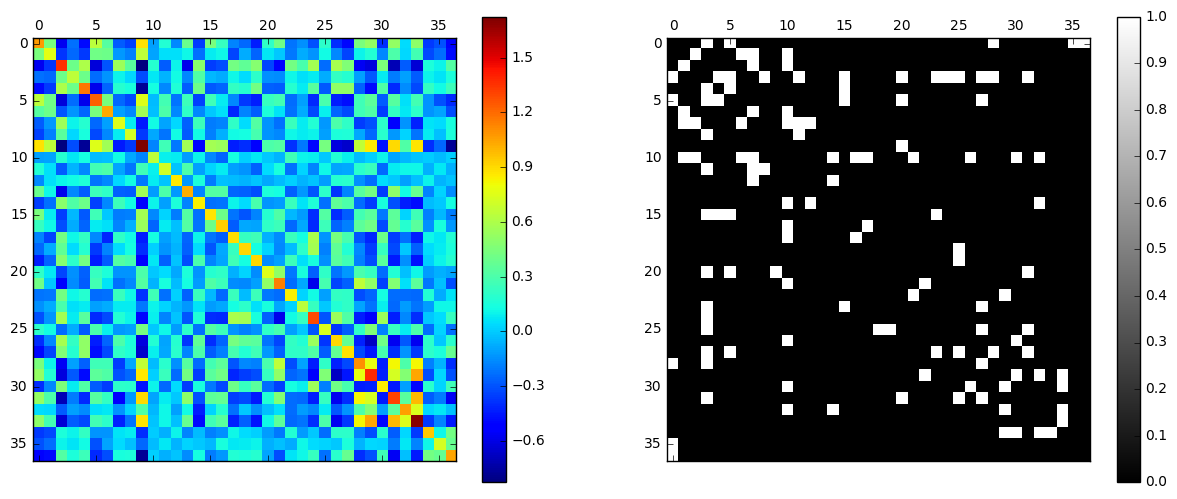

In [41]:
n, m = X0.shape
emp_cov_o = np.cov(X_o)
alpha = 0.4
lambda_s = 1
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(emp_cov_o)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
adjMat =  nx.adjacency_matrix(G1, weight=None).todense()

cax = ax.matshow(adjMat, cmap=plt.cm.gray)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_cov_adjmat.eps"
if savefigure : fig2.savefig(filename)

##  Learning sparse inverse marginal covariance over entire network using gLasso

In [42]:
from graphical_lasso import sparse_inv_cov_glasso 

In [43]:
alpha = 4e-1

In [44]:
covariance_all, precision_all = sparse_inv_cov_glasso(X0, alpha=alpha, max_iter = 100)

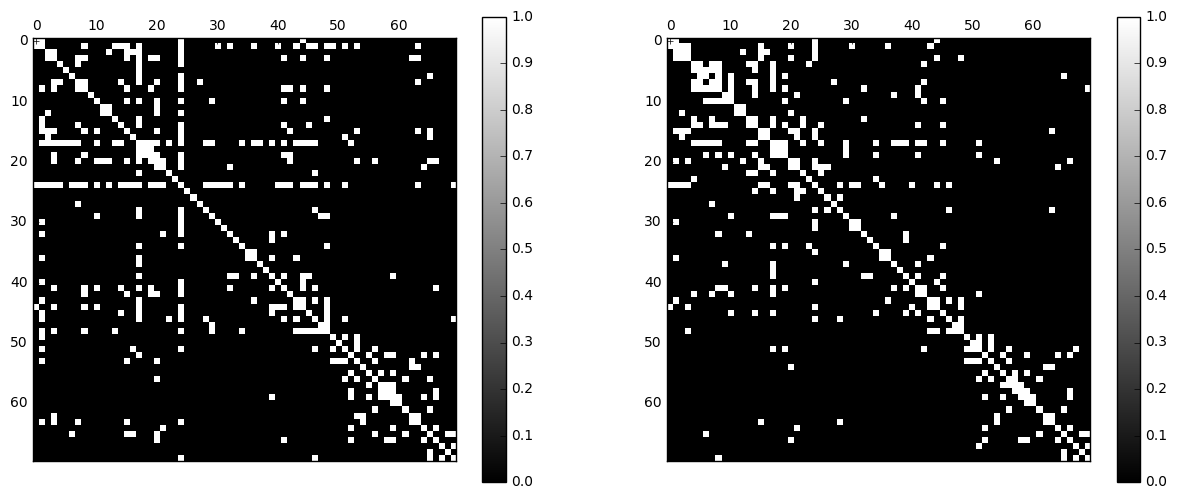

In [45]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(sp.sign(abs(precision_all)), cmap=plt.cm.gray)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
cax = ax.matshow(sp.sign(abs(Laplacian)), cmap=plt.cm.gray)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian.eps"
if savefigure : fig2.savefig(filename)

##  Learning sparse inverse marginal covariance using generalized Laplacian 

In [46]:
from generalized_Laplacian_estimate import generalized_Laplacian_estimate

In [47]:
gen_Laplacian = generalized_Laplacian_estimate(X0, max_iter = 2000)

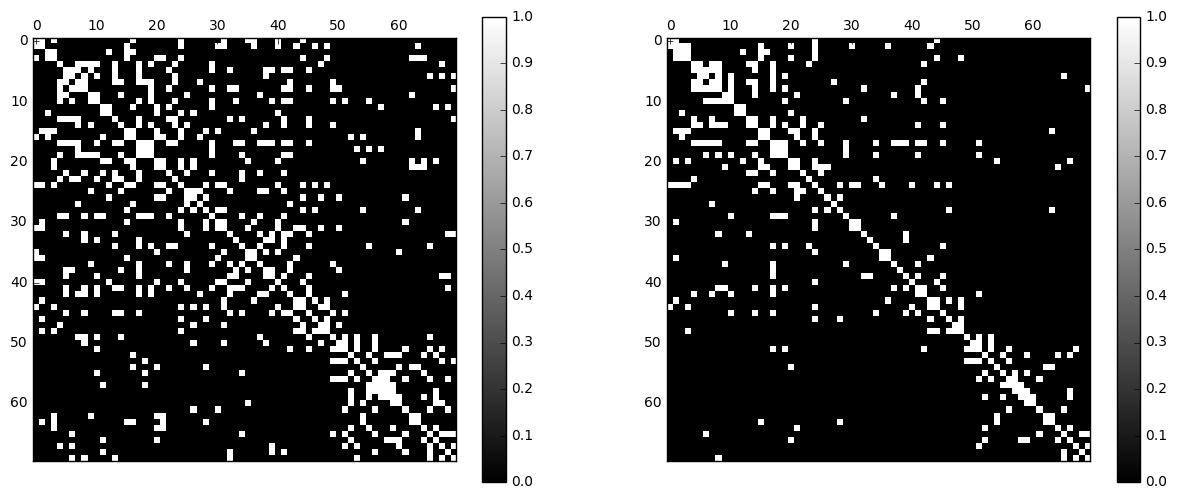

In [48]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(sp.sign(abs(gen_Laplacian)), cmap=plt.cm.gray)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
cax = ax.matshow(sp.sign(abs((Laplacian))), cmap=plt.cm.gray)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian_genLap.eps"
if savefigure : fig2.savefig(filename)

##  Learning sparse inverse marginal covariance using gLasso

In [49]:
alpha = 4.5e-1

In [50]:
from graphical_lasso import sparse_inv_cov_glasso 

In [51]:
covariance, precision = sparse_inv_cov_glasso(X_o, alpha=alpha, max_iter = 100)

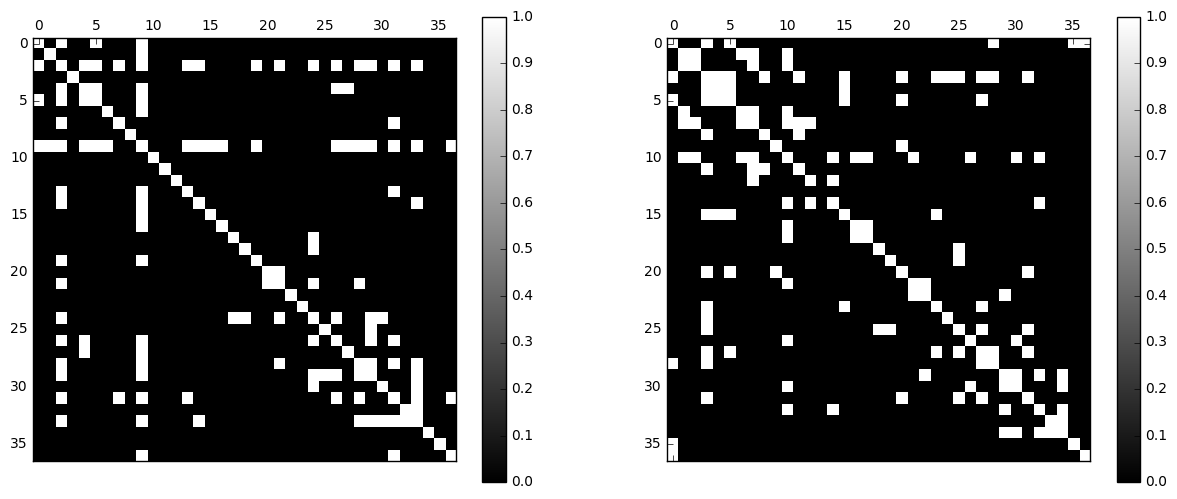

In [52]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(sp.sign(abs(precision)), cmap=plt.cm.gray)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
cax = ax.matshow(sp.sign(abs(Laplacian1)), cmap=plt.cm.gray)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian.eps"
if savefigure : fig2.savefig(filename)

## Learning  sparse inverse conditional covariance using Latent_variable_GMM

In [53]:
from latent_graphical_lasso import latent_variable_gmm_cvx, latent_variable_glasso_data

/home/tianpei/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [54]:
#alpha = 0.005
#sparse_cvx_o, low_rank_cvx_o = latent_variable_gmm_cvx(X_o, alpha=alpha, lambda_s=1, verbose=True)

In [55]:
#import pywt
#fig2= plt.figure(2, figsize=(15,6))
#ax = fig2.add_subplot(121)
#cax = ax.matshow(sp.sign(abs(pywt.threshold(sparse_cvx_o, 1e-4, 'hard'))), cmap=plt.cm.gray)
#fig2.colorbar(cax)

#ax = fig2.add_subplot(122)
#Laplacian1 = nx.normalized_laplacian_matrix(G1, weight=None).todense()
#cax = ax.matshow(sp.sign(abs(Laplacian1)), cmap=plt.cm.gray)
#fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])


#plt.show()
#filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian.eps"
#if savefigure : fig2.savefig(filename)

## Learning sparse inverse conditional covariance using EM-glasso

In [56]:
mask = np.zeros((len(G0), len(G0)))
mask[np.ix_(observed_idx[0:40],hidden_idx)] = np.ones((len(observed_idx[0:40]), len(hidden_idx)))
mask[np.ix_(hidden_idx, observed_idx[0:40])] = np.ones(( len(hidden_idx), len(observed_idx[0:40])))
mask[np.ix_(observed_idx, observed_idx)] = np.ones((len(node_sets[0]), len(node_sets[0])))

In [57]:
alpha = 8e-3
covariance_em_o, precision_em_o, _, prec_all_list_em, dsol_list = \
                    latent_variable_glasso_data(X_o, X_h, alpha=alpha, max_iter_out = 400, 
                                                verbose=False, threshold=5e-3, return_hists=True)

 46%|████▌     | 183/400 [02:49<03:32,  1.02it/s]

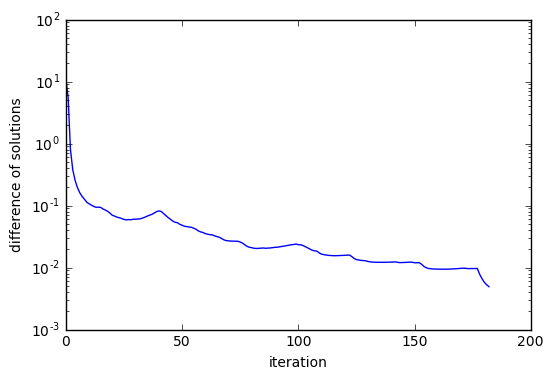

In [58]:
plt.semilogy(dsol_list)
plt.xlabel('iteration')
plt.ylabel('difference of solutions')
plt.show()

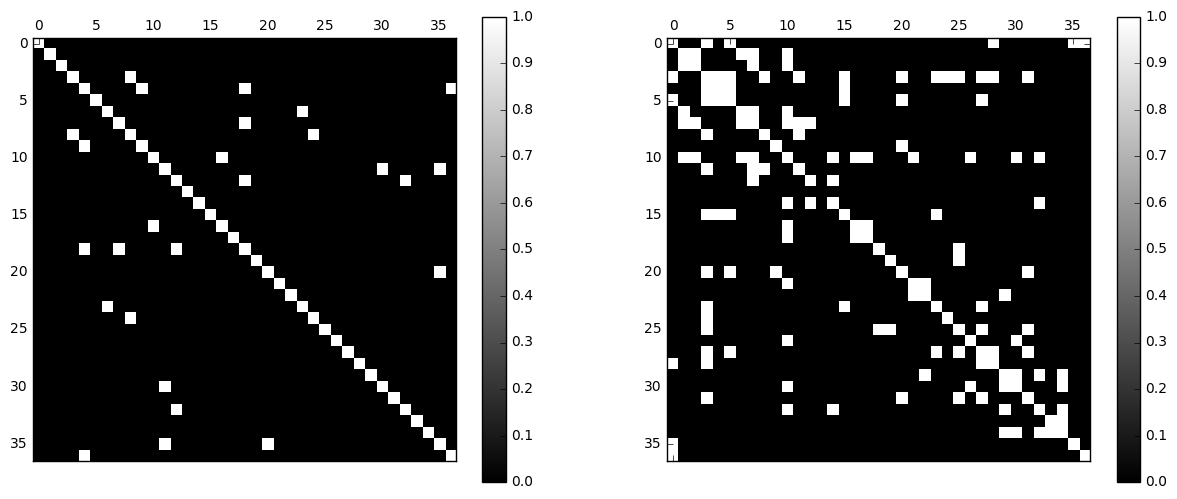

In [59]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(sp.sign(abs(precision_em_o)), cmap=plt.cm.gray)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)



cax = ax.matshow(sp.sign(abs(Laplacian1)), cmap=plt.cm.gray)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian_em.eps"
if savefigure : fig2.savefig(filename)